In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/face-mask-detection/annotations/maksssksksss737.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss410.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss537.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss295.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss771.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss234.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss620.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss70.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss281.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss393.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss296.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss756.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss260.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss57.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss224.xml
/kaggle/inpu

In [2]:
import os 
import numpy 


## Create Folders for Data Prepration

In [3]:
os.mkdir("./train_data")
os.mkdir("./train_data/images")
os.mkdir("./train_data/labels")
os.mkdir("./train_data/images/train")
os.mkdir("./train_data/images/val")
os.mkdir("./train_data/labels/train")
os.mkdir("./train_data/labels/val")

 # *Convert xml files to txt files because yolo expects txt files with normalized bounding boxes* 

In [4]:
import xml.etree.ElementTree as ET
from xml.dom.minidom import parse



path = "../input/face-mask-detection/annotations"
classes = {"with_mask":0,"without_mask":1,"mask_weared_incorrect":2}

for annotations in os.listdir(path):
    
    
    dom = parse(os.path.join(path,annotations))
    root = dom.documentElement
    filename = ".txt".join(root.getElementsByTagName("filename")[0].childNodes[0].data.split(".png"))
    
    image_width = root.getElementsByTagName("width")[0].childNodes[0].data
    image_height = root.getElementsByTagName("height")[0].childNodes[0].data
    with open("./train_data/labels/train/"+filename,"w") as r:
        
        for items in root.getElementsByTagName("object") :
            
            name = items.getElementsByTagName("name")[0].childNodes[0].data
            xmin = items.getElementsByTagName("xmin")[0].childNodes[0].data
            ymin = items.getElementsByTagName("ymin")[0].childNodes[0].data
            xmax = items.getElementsByTagName("xmax")[0].childNodes[0].data
            ymax = items.getElementsByTagName("ymax")[0].childNodes[0].data
            x_center_norm = ((int(xmin)+int(xmax)) / 2 ) / int(image_width)
            y_center_norm = ((int(ymin)+int(ymax))/2) / int(image_height)
            width_norm = ((int(xmax)-int(xmin))/int(image_width))
            height_norm = ((int(ymax)-int(ymin))/int(image_height))
            
            r.write(str(classes[name]))
            r.write(" ")
            r.write(str(x_center_norm))
            r.write(" ")
            r.write(str(y_center_norm))
            r.write(" ")
            r.write(str(width_norm))
            r.write(" ")
            r.write(str(height_norm))
            r.write("\n")
            

# *Check if we  created same  amount of txt files as xml files that are in annotations*

In [5]:
len(os.listdir("./train_data/labels/train/")) == len(os.listdir("../input/face-mask-detection/images"))

True

# *Copy images to train_data/images/train folder*


In [6]:
import shutil
path = "../input/face-mask-detection/images"
for images in os.listdir(path):
    image_path = os.path.join(path,images)
    shutil.copy(image_path,"./train_data/images/train/"+images)

# *Check if images are equal to labels*

In [7]:
len(os.listdir("./train_data/images/train/")) == len(os.listdir("./train_data/labels/train/"))

True

# *Shuffle and move to val folders to create train-val split*

In [8]:
from random import shuffle
from glob import glob
import random
import shutil

random.seed(42)
files = glob("./train_data/images/train/*.png")
shuffle(files)
txt_train_path = "./train_data/labels/train/"
img_train_path = "./train_data/images/train/"
txt_val_path = "./train_data/labels/val/"
img_val_path = "./train_data/images/val/"
for i in files[:120]:
    
    filename = i.split("/")[-1]
    shutil.move(txt_train_path+filename.replace(".png",".txt"),txt_val_path+filename.replace(".png",".txt"))
    shutil.move(img_train_path+filename,img_val_path+filename)

# *Check if val labels and val images are equal*

In [9]:
len(os.listdir("./train_data/labels/val/")) == len(os.listdir("./train_data/images/val/"))

True

# *Create data.yaml file that points to our dataset in a primitive way :)*

In [10]:
with open("/kaggle/working/data.yaml","w") as f:
    f.write("train: ")
    f.write("/kaggle/working/train_data/images/train/")
    f.write("\n")
    f.write("val: ")
    f.write("/kaggle/working/train_data/images/val/")
    f.write("\n")
    f.write("nc: ")
    f.write(" 3")
    f.write("\n")
    f.write("names: ")
    f.write(" ['with_mask','without_mask','mask_weared_incorrect']")
    
    

# *Let's see our data.yaml file* 

In [11]:
with open("/kaggle/working/data.yaml","r") as f:
    print(f.read())

train: /kaggle/working/train_data/images/train/
val: /kaggle/working/train_data/images/val/
nc:  3
names:  ['with_mask','without_mask','mask_weared_incorrect']


# *Clone Yolov5 repo*

In [12]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 7746, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 7746 (delta 32), reused 29 (delta 15), pack-reused 7688
Receiving objects: 100% (7746/7746), 9.35 MiB | 27.20 MiB/s, done.
Resolving deltas: 100% (5328/5328), done.


In [13]:
%cd yolov5

/kaggle/working/yolov5


In [14]:
!pip install -r requirements.txt

# *Uninstall wandb if you don't need it.Also if you are having problems of interacting with the cell,this is the only work around I found.*

In [15]:
!pip uninstall -q -y wandb 

# *Let's train!*

In [16]:
!python train.py --img 640 --batch 32 --epochs 40 --data /kaggle/working/data.yaml --weights yolov5s.pt --cache 

train: weights=yolov5s.pt, cfg=, data=/kaggle/working/data.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=40, batch_size=32, img_size=[640], rect=False, resume=False, nosave=False, notest=False, noautoanchor=False, evolve=None, bucket=, cache_images=True, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, entity=None, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias=latest, local_rank=-1
github: up to date with https://github.com/ultralytics/yolov5 ✅
2021-07-04 17:03:05.574596: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
wandb: Install Weights & Biases for YOLOv5 logging with 'pip install wandb' (recommended)
100%|██████████████████████████████████████| 14.1M/14.1M [00:00<00:00, 43.8MB/s]

train: Scanning '/kaggle/working/train_data/labels/train'

# *Visualize one of our batch predictions.*

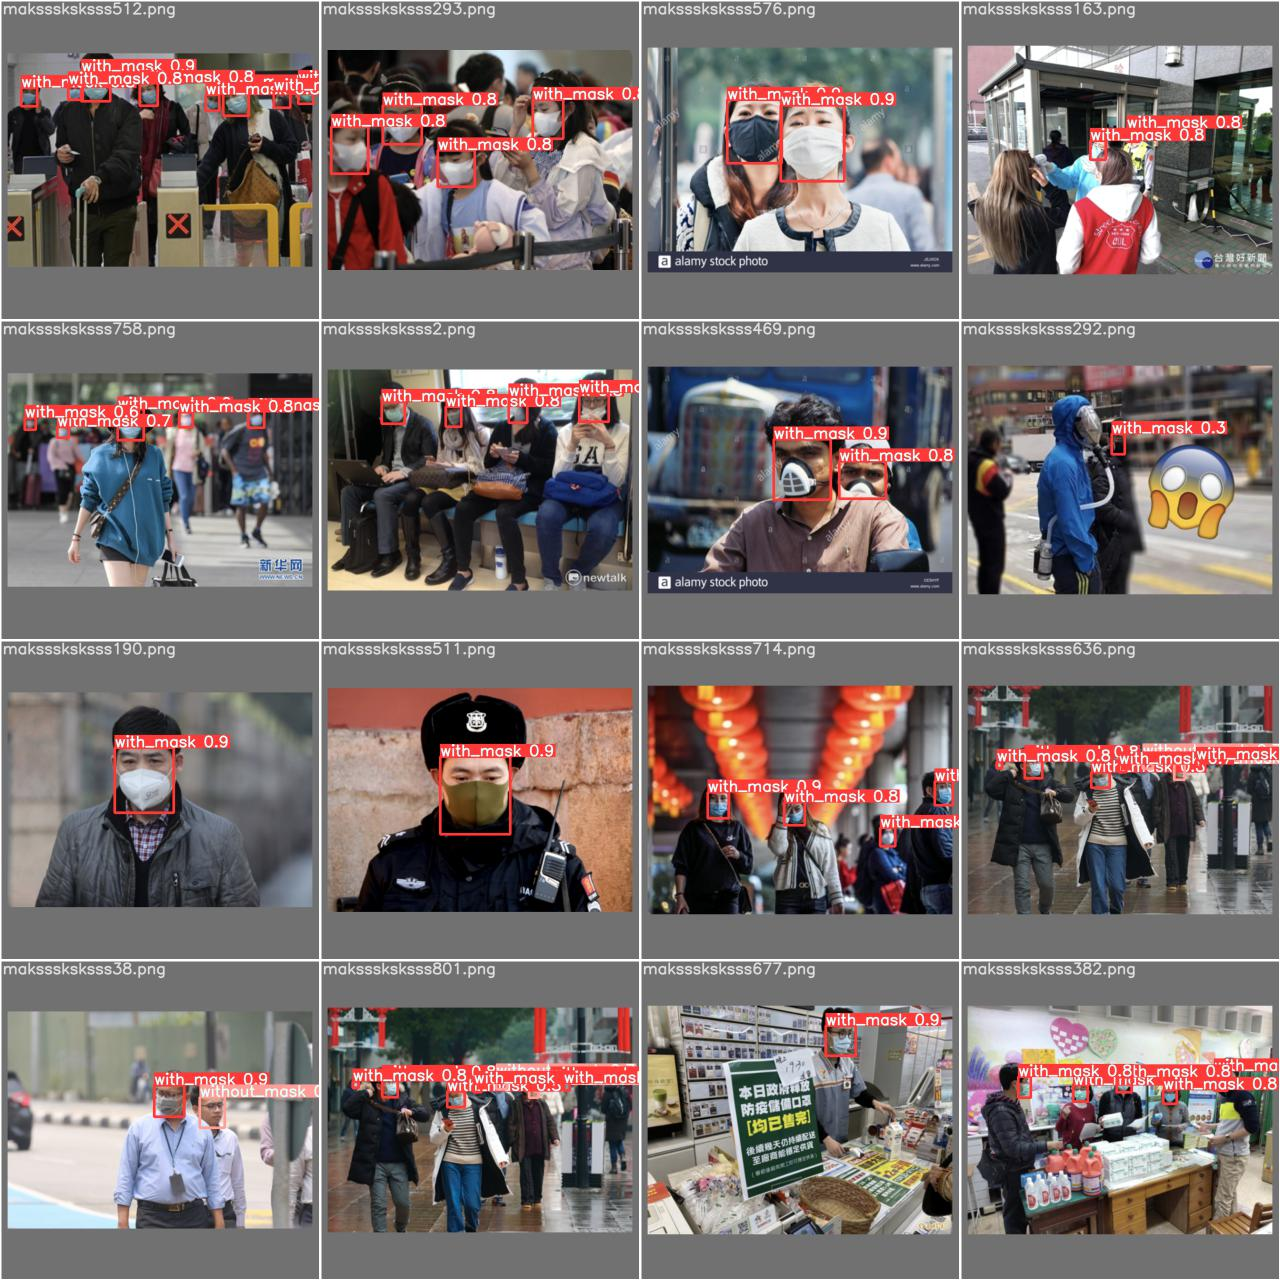

In [17]:
# display detected images
from IPython.display import Image
Image('/kaggle/working/yolov5/runs/train/exp/test_batch1_pred.jpg')

# *Inference on a photo*

In [21]:
!wget https://www.ed.ac.uk/files/styles/landscape_breakpoints_theme_uoe_mobile_1x/public/thumbnails/image/gettyimages-1215069129_jacoblund.png

--2021-07-04 17:35:07--  https://www.ed.ac.uk/files/styles/landscape_breakpoints_theme_uoe_mobile_1x/public/thumbnails/image/gettyimages-1215069129_jacoblund.png
Resolving www.ed.ac.uk (www.ed.ac.uk)... 129.215.228.101
Connecting to www.ed.ac.uk (www.ed.ac.uk)|129.215.228.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 628123 (613K) [image/png]
Saving to: ‘gettyimages-1215069129_jacoblund.png’

gettyimages-1215069 100%[===================>] 613.40K   340KB/s    in 1.8s    

2021-07-04 17:35:10 (340 KB/s) - ‘gettyimages-1215069129_jacoblund.png’ saved [628123/628123]



In [25]:
!python detect.py --source "/kaggle/working/yolov5/gettyimages-1215069129_jacoblund.png" --weights '/kaggle/working/yolov5/runs/train/exp/weights/best.pt'

detect: weights=['/kaggle/working/yolov5/runs/train/exp/weights/best.pt'], source=/kaggle/working/yolov5/gettyimages-1215069129_jacoblund.png, imgsz=640, conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False
image 1/1 /kaggle/working/yolov5/gettyimages-1215069129_jacoblund.png: 448x640 3 with_masks, 3 without_masks, Done. (0.029s)
Results saved to runs/detect/exp2
Done. (0.077s)


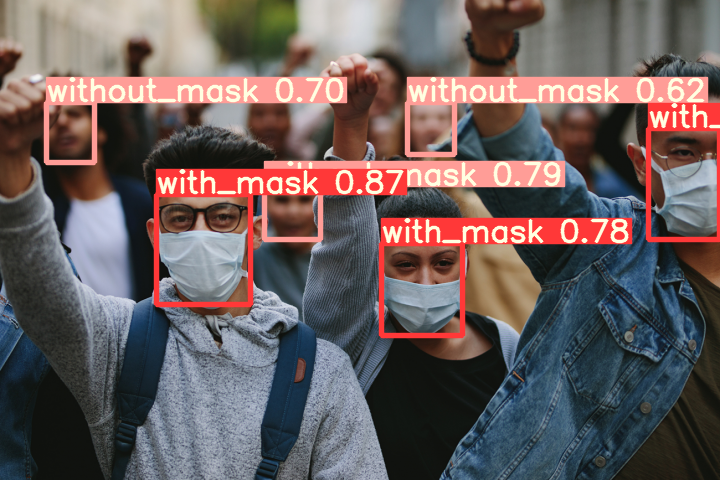

In [34]:
Image("/kaggle/working/yolov5/runs/detect/exp/gettyimages-1215069129_jacoblund.png")

# *END !!*